<a href="https://colab.research.google.com/github/rudycav/Equities-Digital-Assets-Prediction-Model/blob/main/Project/%20Crypto_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [304]:
import numpy as np
import math
import tensorflow
import requests
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from datetime import datetime, timedelta
plt.style.use('fivethirtyeight')
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import sem

In [305]:
def get_crypto_price(symbol, exchange, start_date = None):
    api_key = ' E7KN41UXPEIKWXIK'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df.index.names = ['Date']
 

    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)', 'open', 'high', 'low', 'volume'], axis = 1)

    if start_date:
        df = df[df.index >= start_date]
    return df

crypto_df = get_crypto_price(symbol = 'ETH', exchange = 'USD', start_date = '2018-06-01')
crypto_df.head()

,close
Date,
2019-10-16,174.47
2019-10-17,177.16
2019-10-18,172.74
2019-10-19,171.79
2019-10-20,175.22


In [306]:
forecast_days = 7

def create_prediction_column(df):
  crypto_df['forecast'] = crypto_df[['close']].shift(-forecast_days)

  return crypto_df

prediction_column = create_prediction_column(crypto_df)
prediction_column

,close,forecast
Date,,
2019-10-16,174.47,162.35
2019-10-17,177.16,160.38
2019-10-18,172.74,181.50
2019-10-19,171.79,179.49
2019-10-20,175.22,183.75
...,...,...
2022-07-07,1237.49,NaN
2022-07-08,1214.04,NaN
2022-07-09,1217.02,NaN


In [307]:
def exponential_weight(data, alpha):
  # Exponential weight collects more accurate float integers
  return data.ewm(alpha=alpha).mean()

exp_weight = exponential_weight(eth_df, 0.65)

exp_weight.head()

,close
Date,
2019-10-16,174.470000
2019-10-17,176.462593
2019-10-18,173.934516
2019-10-19,172.519344
2019-10-20,174.284039


In [308]:
def independent_dataset(df):
  X = np.array(prediction_column.close)
  X = X[:-forecast_days]

  return X

x_dataset = independent_dataset(exp_weight)


In [309]:
def dependent_dataset(df):
  y = prediction_column.forecast.values
  y = y[:-forecast_days]

  return y

y_dataset = dependent_dataset(exp_weight)


In [310]:
def split_data(X_data, y_data, test_size):
  X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.3)

  return X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test

X_train, X_test, y_train, y_test = split_data(x_dataset, y_dataset, test_size=0.3)


In [311]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

lin_reg_model.score(X_test, y_test)

0.9682112962522185

In [312]:
actual_price = np.array(eth_df[['close']])[-forecast_days:]


In [313]:
forecast_prediction = lin_reg_model.predict(actual_price)
forecast_prediction

array([1141.59714029, 1194.19338135, 1243.72548039, 1220.9146453 ,
       1223.81342093, 1176.47972221, 1167.40402535])

In [314]:
fd = []
dated = datetime.now()
for i in range(forecast_days): 
  dated += timedelta(days=1)
  fd.append(dated.strftime('%Y-%m-%d'))
fd

['2022-07-12',
 '2022-07-13',
 '2022-07-14',
 '2022-07-15',
 '2022-07-16',
 '2022-07-17',
 '2022-07-18']

In [315]:
forecast_df = pd.DataFrame(forecast_prediction, columns=['forecast'])
forecast_df['Date'] = fd
forecast_df.set_index('Date', inplace=True)
forecast_df

,forecast
Date,
2022-07-12,1141.597140
2022-07-13,1194.193381
2022-07-14,1243.725480
2022-07-15,1220.914645
2022-07-16,1223.813421
2022-07-17,1176.479722
2022-07-18,1167.404025


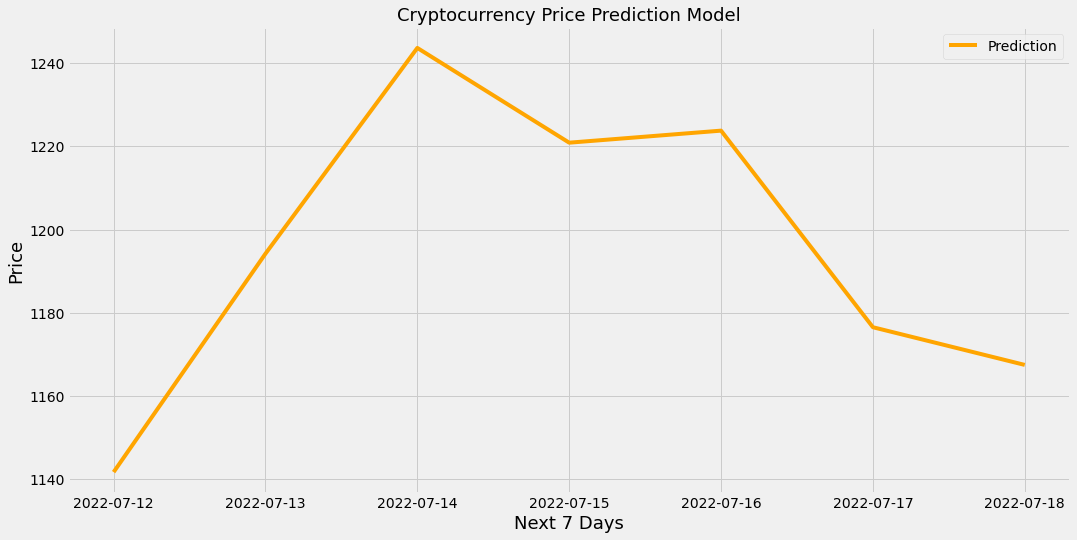

In [316]:
plt.figure(figsize=(16,8))
plt.plot(forecast_df.forecast, color='orange', label = 'Prediction')
plt.title('Cryptocurrency Price Prediction Model', fontsize=18)
plt.xlabel(f'Next {forecast_days} Days', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='upper right')
plt.show()